# Library Install

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D, Attention, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Dataset Loading

In [2]:
data = pd.read_excel("TBO_4k_train.xlsx")

In [3]:
data

,id,text,T1 Target,T1 Argument,T1 Harmful,T2 Target,T2 Argument,T2 Harmful,T3 Target,T3 Argument,T3 Harmful,T4 Target,T4 Argument,T4 Harmful,T5 Target,T5 Argument,T5 Harmful,T6 Target,T6 Argument,T6 Harmful
0,1158315949990252544,@USER Love it keep up the good work sunshine b...,@USER,fuck em all,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1161787110359273472,Lmaooo y’all got other women telling y’all tha...,y'all,sounds stupid,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1161808970727743488,@USER I feel that sis. They needa begin deacti...,niggas,niggas,YES,niggas,deactivating,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1186683819274801152,"all ""rivalry's"" and shit talking aside im so h...",NaN,shit talking,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1187391554757038081,Black musicians think they have to say a bunch...,Black musicians,homo shit,YES,Black musicians,sad,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1155740944764944384,they really made diavolos death as fucked as p...,NaN,fucked,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3996,1188172208201449472,if they just added bubble shields this meta wo...,NaN,fucking,NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,1185059069968764928,it’s really bitches I should’ve beat the shit ...,bitches,bitches,YES,bitches,beat the shit,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,1159515995641458689,Every time a black woman pop up with some mome...,NaN,Shut the fuck up,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

In [4]:
# Identify the correct column name for labels
label_column = "T1 Harmful"  # Change this if the column name is different
if label_column not in data.columns:
    raise KeyError(f"Column '{label_column}' not found in dataset. Available columns: {data.columns}")

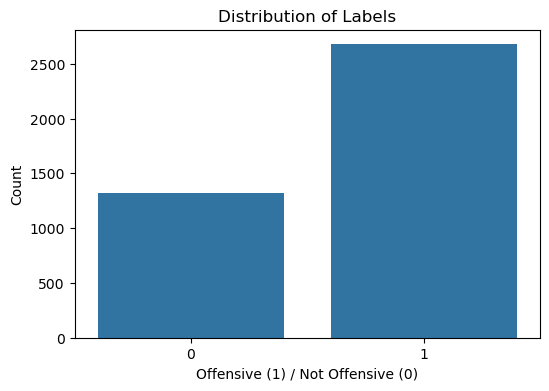

Dataset Statistical Summary:
                 id   T1 Harmful
count  4.000000e+03  4000.000000
mean   1.167642e+18     0.669250
std    3.016885e+16     0.470542
min    7.641410e+09     0.000000
25%    1.159253e+18     0.000000
50%    1.161390e+18     1.000000
75%    1.186639e+18     1.000000
max    1.188714e+18     1.000000


In [16]:
# Data Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x=data[label_column])
plt.title("Distribution of Labels")
plt.xlabel("Offensive (1) / Not Offensive (0)")
plt.ylabel("Count")
plt.show()

# Statistical Summary
print("Dataset Statistical Summary:")
print(data.describe())

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = tf.keras.preprocessing.text.text_to_word_sequence(text)
    return ' '.join(text)

data['text'] = data['text'].astype(str).apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
data[label_column] = data[label_column].map({'YES': 1, 'NO': 0})

# Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Data Splitting

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[label_column], test_size=0.2, random_state=42)

# Build CNN Model

In [7]:
def build_cnn():
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(set(data[label_column])), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build LSTM Model

In [8]:
def build_lstm():
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        SpatialDropout1D(0.2),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(set(data[label_column])), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build BiLSTM with Attention1

In [10]:
def build_bilstm_attention():
    inputs = Input(shape=(max_len,))
    x = Embedding(max_words, 128, input_length=max_len)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    attention = Attention()([x, x])
    x = GlobalAveragePooling1D()(attention)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(set(data[label_column])), activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train and evaluate models

In [11]:
models = {
    "CNN": build_cnn(),
    "LSTM": build_lstm(),
    "BiLSTM_Attention": build_bilstm_attention()
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{name} - Accuracy: {accuracy:.4f}")


C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training CNN...
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.6513 - loss: 0.6500 - val_accuracy: 0.6963 - val_loss: 0.5359
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7364 - loss: 0.4957 - val_accuracy: 0.7250 - val_loss: 0.5641
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9130 - loss: 0.2456 - val_accuracy: 0.6988 - val_loss: 0.7463
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9768 - loss: 0.0849 - val_accuracy: 0.6800 - val_loss: 1.1109
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9970 - loss: 0.0144 - val_accuracy: 0.7038 - val_loss: 1.3889
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7082 - loss: 1.4236
CNN - Accuracy: 0.7038
Training LSTM...
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.6354 - loss: 0.6547 - val_accuracy: 0.6963 - val_loss: 0.6260
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.6595 - loss: 0.6455 - val_accur

# Deep learning Model performance comparison

In [20]:
results = []
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"{name} - Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    results.append([name, accuracy])


Training CNN...
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 1.0000 - loss: 1.6228e-04 - val_accuracy: 0.7125 - val_loss: 1.9409
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 1.0000 - loss: 1.0592e-04 - val_accuracy: 0.7063 - val_loss: 1.9883
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 1.0000 - loss: 9.3380e-05 - val_accuracy: 0.7038 - val_loss: 2.0268
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 1.0000 - loss: 8.6585e-05 - val_accuracy: 0.7038 - val_loss: 2.0620
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 1.0000 - loss: 8.3754e-05 - val_accuracy: 0.7125 - val_loss: 2.0995
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7159 - loss: 2.1455
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CNN - Accuracy: 0.7125
              precision    recall  f1-score   support

           0       0.53      0.50      0.51       243
           1       0.79      0.80      0.80       557

    accuracy           

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 290ms/step - accuracy: 0.8997 - loss: 0.3122 - val_accuracy: 0.7100 - val_loss: 0.7095
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - accuracy: 0.9184 - loss: 0.2314 - val_accuracy: 0.7063 - val_loss: 0.8811
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 310ms/step - accuracy: 0.9498 - loss: 0.1687 - val_accuracy: 0.6913 - val_loss: 0.8625
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 347ms/step - accuracy: 0.9714 - loss: 0.1196 - val_accuracy: 0.7000 - val_loss: 1.0120
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.9860 - loss: 0.0584 - val_accuracy: 0.7163 - val_loss: 1.0752
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7466 - loss: 1.0061
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
BiLSTM_Attention - Accuracy: 0.7163
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       243
           1       0.79      0.80      0.80       557

    accuracy                           0.72   


Final Model Comparison:
              Model  Accuracy
0               CNN   0.71250
1              LSTM   0.69625
2  BiLSTM_Attention   0.71625


C:\Users\ACER\AppData\Local\Temp\ipykernel_18492\1789016105.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df["Model"], y=results_df["Accuracy"], palette="Blues")


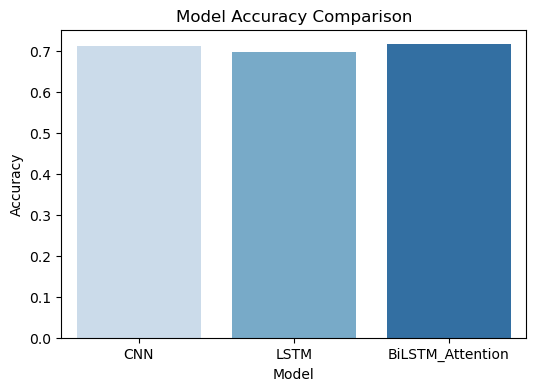

In [21]:
# Comparison Table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
print("\nFinal Model Comparison:")
print(results_df)

# Visualization of Model Comparison
plt.figure(figsize=(6, 4))
sns.barplot(x=results_df["Model"], y=results_df["Accuracy"], palette="Blues")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()